# Breast Cancer Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Breast-Cancer-Data)
3. [Optimizing Architecture](#Conditional-Generative-Adversarial-Network)
4. [Another perspective: Wasserstein Conditional Generative Adversarial Network](#Introducing-the-WGAN)
5. [Final Evaluation](#Evaluating-Synthetic-Data)

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Breast Cancer Data

In [3]:
X, y = load_breast_cancer()['data'], load_breast_cancer()['target']
features, classes = load_breast_cancer()['feature_names'], load_breast_cancer()['target_names']

real_bc = pd.DataFrame(X, columns = features)
real_bc['target'] = y
real_bc['target'] = real_bc['target'].map({i: classes[i] for i in range(len(classes))})
print(f'{real_bc.shape[0]} row x {real_bc.shape[1]} columns = {real_bc.shape[0] * real_bc.shape[1]} values')
real_bc.head()

569 row x 31 columns = 17639 values


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


The dataset contains 30 features derived from analysis of digitized images of fine-needle aspirates of breast nodules. Each feature represents a measure of the properties of the tumor cell nucleus.

The features are divided into three categories for each of the 10 core properties of the nucleus:
1. **Radius (`radius_mean`, `radius_se`, `radius_worst`)** - Mean, standard deviation and worst-case value of the average distance from the center to the points on the core perimeter.  
2. **Texture (`texture_mean`, `texture_se`, `texture_worst`)** - Variation of intensity in adjacent pixels.  
3. **Perimeter (`perimeter_mean`, `perimeter_se`, `perimeter_worst`)** - Total length of the core contour.  
4. **Area (`area_mean`, `area_se`, `area_worst`)** - Area occupied by the cell nucleus.  
5. **Complexity (`smoothness_mean`, `smoothness_se`, `smoothness_worst`)** - Uniformity of the contours of the nucleus.  
6. **Compactness (`compactness_mean`, `compactness_if`, `compactness_worst`)** - Relationship between area and perimeter of the core.  
7. **Concavity (`concavity_mean`, `concavity_se`, `concavity_worst`)** - Gravity of indentations along the perimeter of the core.  
8. **Number of concavities (`concave points_mean`, `concave points_se`, `concave points_worst`)** - Number of concave points along the core boundary.  
9. **Symmetry (`symmetry_mean`, `symmetry_se`, `symmetry_worst`)** - Similarity between the two halves of the core.  
10. **Fractal Dimension (`fractal_dimension_mean`, `fractal_dimension_se`, `fractal_dimension_worst`)** - Measure of the complexity of the shape of the core based on the fractal dimension.

357 instances are classified as **benign** and 212 as **malignant**.

The dataset is significantly larger than Iris, real-world data you won't scare us away 😎.

To facilitate numerical and graphical comparisons we will try to apply the **Principal Component Analysis** dimensional reduction technique by going to select only those new features that guarantee the trade-off between explained variance and number of components.

In [14]:
from sklearn.decomposition import PCA

pca = PCA()
decompesed_bc_array = pca.fit_transform(real_bc.select_dtypes('number'))
decomposed_df = pd.DataFrame(decompesed_bc_array, columns = [f'Component {idx + 1}' for idx in range(decompesed_bc_array.shape[1])])

The dataset with reduced dimensionality is ready! The next step is to choose the right number of components by analyzing the percentage of variance explained.

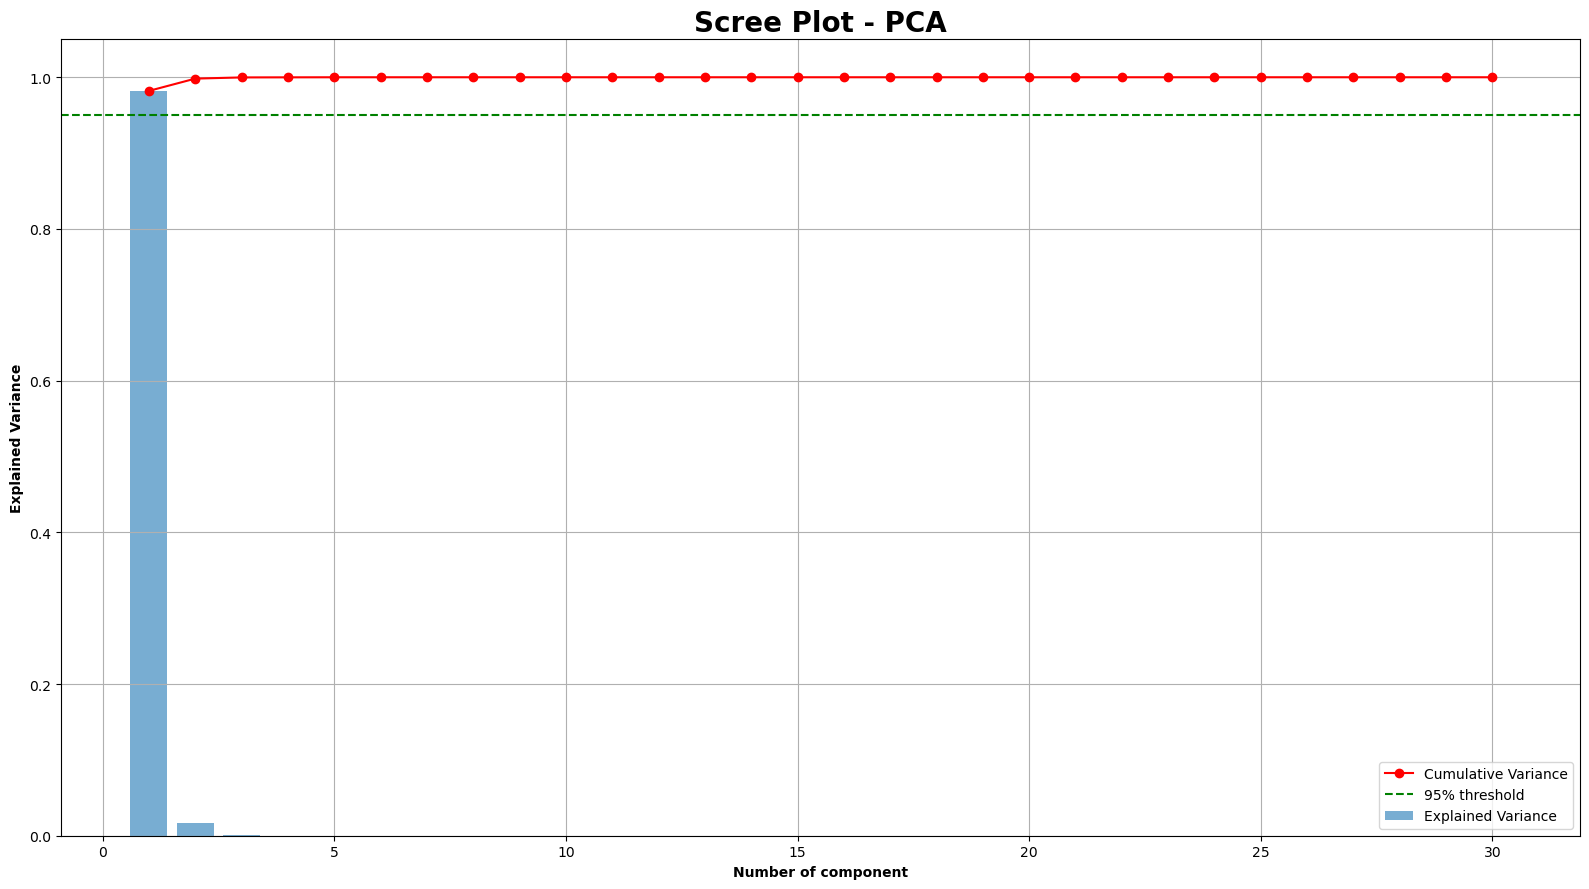

In [44]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize = (16, 9))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha = 0.6, label = 'Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker = 'o', linestyle = '-', color = 'r', 
         label = 'Cumulative Variance')
plt.axhline(y = 0.95, color = 'g', linestyle = '--', label = '95% threshold')

plt.xlabel('Number of component', weight = 'bold')
plt.ylabel('Explained Variance', weight = 'bold')
plt.title('Scree Plot - PCA', fontsize = 20, weight = 'bold')
plt.legend()
plt.grid()

plt.tight_layout();

The original features are highly correlated, so with just a few components we can explain almost 100% of the variance. We try to figure out what the optimal number of components might be.

In [45]:
print('Cumulative Explained Variance:')

for idx, value in enumerate(cumulative_variance):
    print(f'N° {idx + 1}: {value:.4%}')

Cumulative Explained Variance:
N° 1: 98.2045%
N° 2: 99.8221%
N° 3: 99.9779%
N° 4: 99.9900%
N° 5: 99.9988%
N° 6: 99.9995%
N° 7: 99.9999%
N° 8: 99.9999%
N° 9: 100.0000%
N° 10: 100.0000%
N° 11: 100.0000%
N° 12: 100.0000%
N° 13: 100.0000%
N° 14: 100.0000%
N° 15: 100.0000%
N° 16: 100.0000%
N° 17: 100.0000%
N° 18: 100.0000%
N° 19: 100.0000%
N° 20: 100.0000%
N° 21: 100.0000%
N° 22: 100.0000%
N° 23: 100.0000%
N° 24: 100.0000%
N° 25: 100.0000%
N° 26: 100.0000%
N° 27: 100.0000%
N° 28: 100.0000%
N° 29: 100.0000%
N° 30: 100.0000%


Following the start simple get bigger principle we will start by using only 5 components that guarantee us almost all of the variance explained.

In [46]:
bc_pca = pd.DataFrame(decompesed_bc_array)
bc_pca = bc_pca.iloc[:, :5]
bc_pca.columns = [f'Component {idx + 1}' for idx in range(5)]
bc_pca['target'] = y
bc_pca['target'] = bc_pca['target'].map({i: classes[i] for i in range(len(classes))})
bc_pca.head()

,Component 1,Component 2,Component 3,Component 4,Component 5,target
0,1160.142574,-293.917544,48.578398,-8.711975,32.000486,malignant
1,1269.122443,15.630182,-35.394534,17.861283,-4.334874,malignant
2,995.793889,39.156743,-1.709753,4.199340,-0.466529,malignant
3,-407.180803,-67.380320,8.672848,-11.759867,7.115461,malignant
4,930.341180,189.340742,1.374801,8.499183,7.613289,malignant


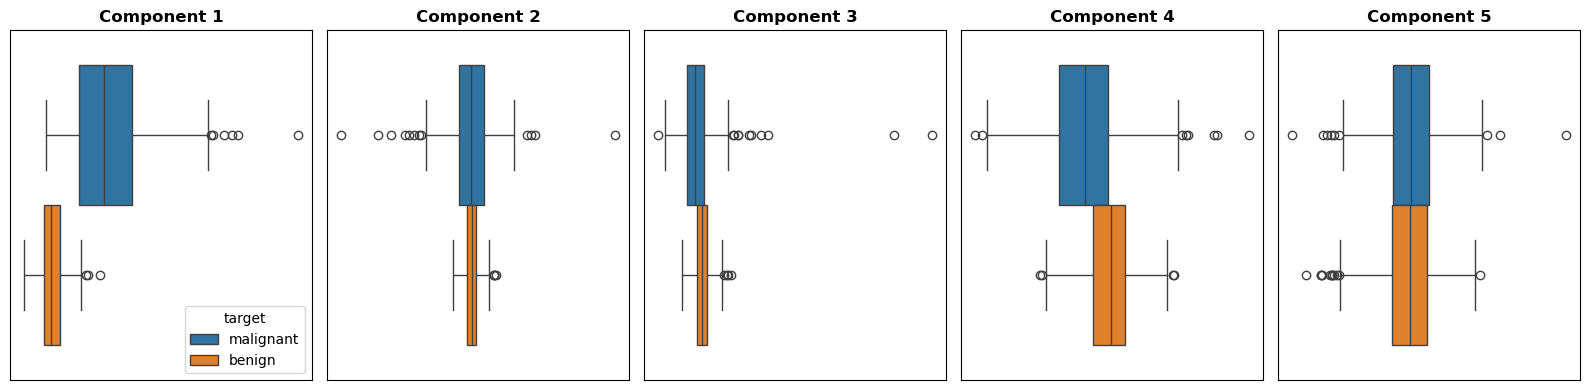

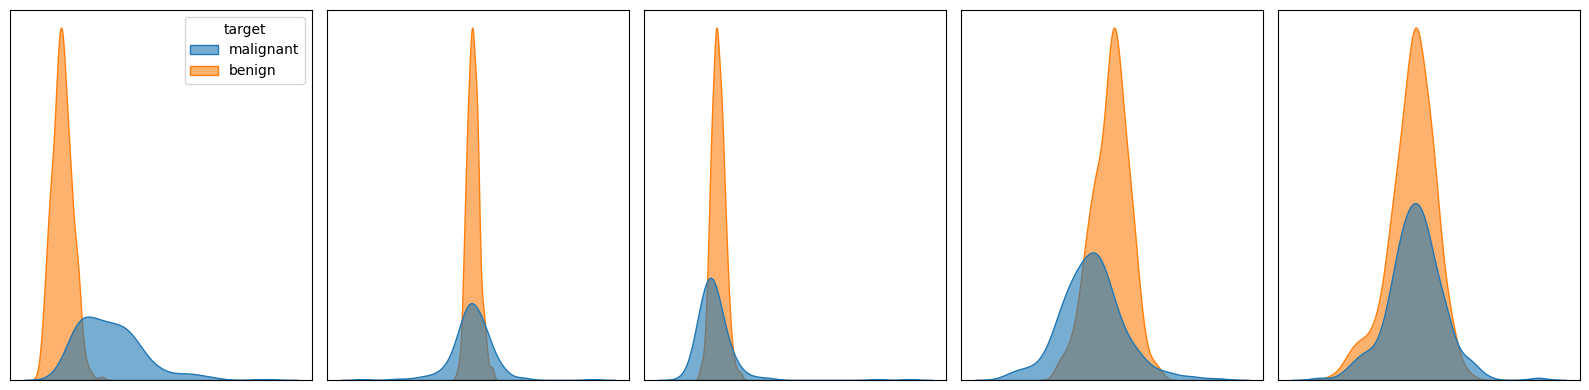

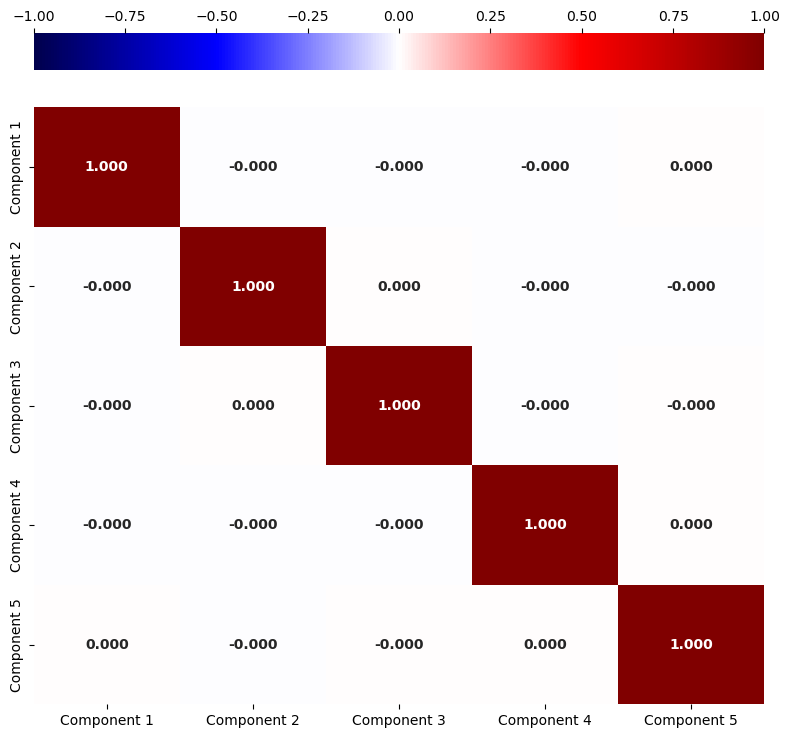

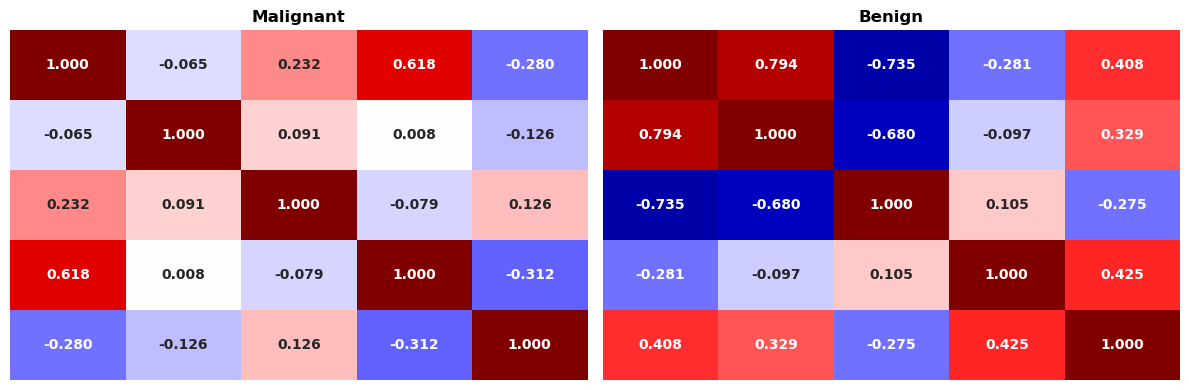

In [47]:
utils.plot_data(bc_pca, 'target')